In [76]:
# Required libraries
from random import randint, seed
import numpy as np
import matplotlib.pyplot as plt


In [77]:
# Implement powersets
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1))

In [78]:
class Adaline:
	def __init__(self, n, rate = 0.2, thresh = 0.5, final = False):
		self.countOfNeurons = n+1
		self.learningRate = rate
		self.thresh = thresh
		self.weights = np.random.random((1,(n+1)))[0]
  
		if final == True:
			self.weights = np.random.random((1,(n+1)))[0]
			
	def activation(self, x):
		if x > self.thresh:
			return 1
				
		else:
			return 0
				
	def _update(self, x, d):
		x = np.pad(x, (1, 0), constant_values = 1)

		# Forward pass
		z = np.dot(x, self.weights)
		z = self.activation(z)
		
		d = d - z
		changes = x*d*self.learningRate

		return changes

	def fit(self, x, d, info = False):
		flag = True
			
		# If any weights are updates, recalculate for all samples
		while (flag):
			flag = False
			changes = [0]*self.countOfNeurons
				
			for i in range(len(x)):

				# Calculate the required changes
				if (self.predict(x[i])[1] != d[i]):
					flag = True
					changes = self._update(x[i], d[i])
					self.weights += changes

		if not info :
			return
			
		# 100% convergence
		print("Training Complete")
		print(self.weights)
   
		return

	def predict(self, x):
		
		x = np.pad(x, (1, 0), constant_values = 1)
		a = np.dot(x, self.weights)
		z = self.activation(a)
		
		# Return both affine and binary output
		return a, z

In [80]:
class Madaline:
    def __init__(self, n, hid, rate = 0.3, thresh = 0.5):
        self.NoOfNeurons = n+1
        self.NoOfHiddenNeurons = hid
        self.learningRate = rate
        self.threshold = thresh
        self.nUnits = [Adaline(n, rate, thresh) for i in range(hid)]
        self.finalLayer = Adaline(hid, rate, thresh, final = True)

        # Print the initial weights
        print("Initial Weights: ")
        for i in range(len(self.nUnits)):
            print(self.nUnits[i].weights)
        print()
        
    
    def activation(self, x):
        if x > self.threshold:
            return 1
        else:
            return 0
    
    def predict(self, s):
      hiddenLayerAffines = []
      hiddenLayerOutputs = []
              
      for j in self.nUnits:
          prediction = j.predict(s)
          hiddenLayerOutputs.append(prediction[1])
          hiddenLayerAffines.append(prediction[0])

      finalLayerAffine, finalLayerOutput = self.finalLayer.predict(hiddenLayerOutputs)

      return finalLayerOutput

    def fit(self, x, d, info=False):
        flag = True
        mis = 0
        max = 200
        # max = 1e7
        forAll = False
        
        # Calculate the initial accuracy.
        initWeights = []
        for i in range(len(self.nUnits)):
            initWeights.append(self.nUnits[i].weights)
        
        prevAccuracy = self.accuracy(x, d, initWeights)
        
        noLoop = 0

        while(flag and noLoop < max):
            noLoop += 1
            
            flag = False
            changed = False
            
            for i in range(len(x)):

                if changed == True:
                    break
                
                
                hiddenLayerAffines = []
                hiddenLayerOutputs = []
                for j in self.nUnits:
                    prediction = j.predict(x[i])
                    hiddenLayerOutputs.append(prediction[1])
                    hiddenLayerAffines.append(abs(prediction[0]))
               
                # Calculate the predicted value
                finalLayerAffine, finalLayerOutput = self.finalLayer.predict(hiddenLayerOutputs)

                # Misclassified sample
                if (finalLayerOutput != d[i]):
                    print(finalLayerAffine)
                    print(prevAccuracy)
                    
                    flag = True
                    changed = False

                    toUpdateList = [x for _, x in sorted(zip(hiddenLayerAffines, self.nUnits), key = lambda pair: pair[0])]
                    toUpdateListIndexes = [x for _, x in sorted(zip(hiddenLayerAffines, list(range(self.NoOfHiddenNeurons))))]
                
                    flippedHiddenLayerOutputs = hiddenLayerOutputs[:]
                        
                    for m in range(len(toUpdateList)):
                        flippedHiddenLayerOutputs[toUpdateListIndexes[m]] = 1 if hiddenLayerOutputs[toUpdateListIndexes[m]] == 0 else 0
                        
                        flippedFinalLayerAffine, flippedFinalLayerOutput = self.finalLayer.predict(flippedHiddenLayerOutputs)
                        
                        # Changed weights
                        changes = []
                        forUpdate = []
                        for p in range(len(self.nUnits)):
                            forUpdate.append(self.nUnits[p].weights)

                        
                        toUpdate = self.nUnits[toUpdateListIndexes[m]]
                        changes = toUpdate._update(x[i], flippedHiddenLayerOutputs[toUpdateListIndexes[m]])
                        forUpdate[toUpdateListIndexes[m]] = toUpdate.weights + changes
                            
                        newAcc = self.accuracy(x, d, forUpdate)
                        
                        if (newAcc > prevAccuracy):
                            prevAccuracy = newAcc
                            

                            # Update the actual weights if the update is correct
                            toUpdate = self.nUnits[toUpdateListIndexes[m]]
                            changes = toUpdate._update(x[i], flippedHiddenLayerOutputs[toUpdateListIndexes[m]])
                            toUpdate.weights += changes
                            
                            changed = True
                            break

                        # Update all incorrect weights including  the final layer if no neuron is selected.
                        if (m == len(toUpdateList) - 1):
                            whichToUpdate = []

                            for j in range(len(self.nUnits)):
                                alternative = flippedHiddenLayerOutputs[toUpdateListIndexes[m]]
                                new_activation = self.activation(finalLayerAffine - hiddenLayerAffines[j] + alternative)
                                new_z = self.activation(new_activation)
                                if new_z == self.predict(x[i]):
                                    whichToUpdate.append(j)
                                    self.nUnits[j].fit([x[i]], [d[i]])
                                
                            self.finalLayer.fit([hiddenLayerOutputs], [d[i]])
                            changed = True
                            break;

                        
        if not info:
            return

        # Print the information
        print("Training Complete")
        print("Model Converged")
        print(prevAccuracy)

        print("Final Weights")
        for i in range(len(self.nUnits)):
            print(self.nUnits[i].weights)
        print()
        


        return

  
    def accuracy(self, x, d, newWs):

        accuracy = 0

        for i in range(len(x)):

            hiddenLayerAffines = []
            hiddenLayerOutputs = []
            
            for j in range(len(self.nUnits)):

                x2 = np.pad(x[i], (1, 0), constant_values = 1)

                z = np.dot(x2, newWs[j])
                z = self.activation(z)
                hiddenLayerOutputs.append(z)
                
            finalLayerAffine, finalLayerOutput = self.finalLayer.predict(hiddenLayerOutputs)

            if (finalLayerOutput == d[i]):
                accuracy += 1

        return accuracy




In [ ]:
# class Madaline:
#     def __init__(self, n, hid, rate = 0.3, thresh = 0.5):
#         self.NoOfNeurons = n+1
#         self.NoOfHiddenNeurons = hid
#         self.learningRate = rate
#         self.threshold = thresh
#         self.nUnits = [Adaline(n, rate, thresh) for i in range(hid)]
#         self.finalLayer = Adaline(hid, rate, thresh, final = True)

#         # Print the initial weights
#         print("Initial Weights: ")
#         for i in range(len(self.nUnits)):
#             print(self.nUnits[i].weights)
#         print()
        
    
#     def activation(self, x):
#         if x > self.threshold:
#             return 1
#         else:
#             return 0
    
#     def predict(self, s):
#       hiddenLayerAffines = []
#       hiddenLayerOutputs = []
              
#       for j in self.nUnits:
#           prediction = j.predict(s)
#           hiddenLayerOutputs.append(prediction[1])
#           hiddenLayerAffines.append(prediction[0])

#       finalLayerAffine, finalLayerOutput = self.finalLayer.predict(hiddenLayerOutputs)

#       return finalLayerOutput

#     def fit(self, x, d, info=False):
#         flag = True
#         mis = 0
#         max = 10000
        
#         # Calculate the initial accuracy.
#         initWeights = []
#         for i in range(len(self.nUnits)):
#             initWeights.append(self.nUnits[i].weights)
        
#         prevAccuracy = self.accuracy(x, d, initWeights)
#         noLoop = 0

#         while(flag):
#             noLoop += 1
            
#             flag = False
#             changed = False
            
#             for i in range(len(x)):

#                 if changed == True:
#                     break
                
                
#                 hiddenLayerAffines = []
#                 hiddenLayerOutputs = []
#                 for j in self.nUnits:
#                     prediction = j.predict(x[i])
#                     hiddenLayerOutputs.append(prediction[1])
#                     hiddenLayerAffines.append(abs(prediction[0]))
               
#                 # Calculate the predicted value
#                 finalLayerAffine, finalLayerOutput = self.finalLayer.predict(hiddenLayerOutputs)

#                 # Misclassified sample
#                 if (finalLayerOutput != d[i]):
                    
#                     flag = True
#                     changed = False

#                     # Make the powerset after sorting it along the affine values
#                     toUpdateList = [x for _, x in sorted(zip(hiddenLayerAffines, self.nUnits), key = lambda pair: pair[0])]
#                     toUpdateList = list(powerset(toUpdateList))
#                     toUpdateListIndexes = [x for _, x in sorted(zip(hiddenLayerAffines, list(range(self.NoOfHiddenNeurons))))]
#                     toUpdateListIndexes = list(powerset(toUpdateListIndexes))

#                     final = False
#                     for k in range(len(toUpdateList)):

#                         if (k == len(toUpdateList) - 1 or len(toUpdateList[k]) >= 2):
#                             final = True
                            
#                         # print(k)
#                         # Changed outputs
#                         flippedHiddenLayerOutputs = hiddenLayerOutputs[:]
                        
#                         for m in range(len(toUpdateList[k])):
#                             flippedHiddenLayerOutputs[toUpdateListIndexes[k][m]] = 1 if hiddenLayerOutputs[toUpdateListIndexes[k][m]] == 0 else 0
                        
#                         flippedFinalLayerAffine, flippedFinalLayerOutput = self.finalLayer.predict(flippedHiddenLayerOutputs)
                        
#                         # Changed weights
#                         changes = []
#                         forUpdate = []
#                         for p in range(len(self.nUnits)):
#                             forUpdate.append(self.nUnits[p].weights)

                        
#                         for m in range(len(toUpdateList[k])):
#                             toUpdate = self.nUnits[toUpdateListIndexes[k][m]]
#                             changes = toUpdate._update(x[i], flippedHiddenLayerOutputs[toUpdateListIndexes[k][m]])
#                             forUpdate[toUpdateListIndexes[k][m]] = toUpdate.weights + changes
                            
#                             #  New accuracy
#                         newAcc = self.accuracy(x, d, forUpdate)
#                         # print(forUpdate)
                        
#                         if (newAcc > prevAccuracy or final == True):
#                             prevAccuracy = newAcc
                            

#                             # Update the actual weights if the update is correct
#                             for m in range(len(toUpdateList[k])):
#                                 toUpdate = self.nUnits[toUpdateListIndexes[k][m]]
#                                 changes = toUpdate._update(x[i], flippedHiddenLayerOutputs[toUpdateListIndexes[k][m]])
#                                 toUpdate.weights += changes
                            
#                             changed = True
#                             break
                        
#         if not info:
#             return

#         # Print the information
#         print("Training Complete")
#         print("Model Converged")
#         print(prevAccuracy)

#         print("Final Weights")
#         for i in range(len(self.nUnits)):
#             print(self.nUnits[i].weights)
#         print()
        


#         return

  
#     def accuracy(self, x, d, newWs):

#         accuracy = 0

#         for i in range(len(x)):

#             hiddenLayerAffines = []
#             hiddenLayerOutputs = []
            
#             for j in range(len(self.nUnits)):

#                 x2 = np.pad(x[i], (1, 0), constant_values = 1)

#                 z = np.dot(x2, newWs[j])
#                 z = self.activation(z)
#                 hiddenLayerOutputs.append(z)
                
#             finalLayerAffine, finalLayerOutput = self.finalLayer.predict(hiddenLayerOutputs)

#             if (finalLayerOutput == d[i]):
#                 accuracy += 1

#         return accuracy




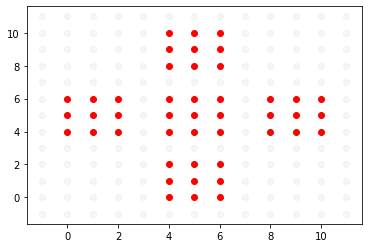

In [81]:
# The training data

# Function for image
def function(x1, x2):
    if (x1 < 0 or x1 > 10 or x2 < 0 or x2 > 10):
        return 0
    if (x1 >= 4 and x1 <= 6):
        if (x2 >= 0 and x2 <= 2) or (x2 >= 4 and x2 <= 6) or (x2 >= 8 and x2 <= 10):
            return 1
    if (x1 >= 0 and x1 <= 2)  or (x1 >= 8 and x1 <= 10):
        if (x2 >= 4 and x2 <= 6):
            return 1 
    return 0

# Making teh data
def makeData():
    train = []
    for x1 in range(-1, 12):
        for x2 in range(-1, 12):
            train.append([x1/10, x2/10, function(x1, x2)])

    return train

# Plotting the data
def plotData(train):
    red_x1 = []
    red_x2 = []
    white_x1 = []
    white_x2 = []

    for pt in train:
        if (pt[2] == 1):
            red_x1.append(pt[0]*10)
            red_x2.append(pt[1]*10)
        else:
            white_x1.append(pt[0]*10)
            white_x2.append(pt[1]*10)

    plt.scatter(red_x1, red_x2, c = 'r', alpha = 1)
    plt.scatter(white_x1, white_x2, c = 'g', alpha = 0.05)
    plt.show()

train = makeData()
plotData(train)

train = np.array(train)
trainX = train.T[0:2]
trainX = trainX.T

trainy = train.T[-1]
trainy = trainy.T

def printAccuracy(ypred, ytrue):
    return np.sum(ypred == ytrue)/len(ypred)


In [91]:
# Training the algorithm for n = 2 and h = 21
seed(0)
n = 2
h = 21
s = trainX
z = trainy
np.random.shuffle(s)
np.random.shuffle(z)
net = Madaline(n, h, 0.01, 0.5)
net.fit(s, z, True)


y_pred = []
for i in s: 
    y_pred.append(net.predict(i))


In [99]:
# Save the model
weights = []
for i in range(len(net.nUnits)):
    weights.append(net.nUnits[i].weights)

fl = net.finalLayer.weights
np.save('q2_21_w.npy', np.array(weights))
np.save('q2_21_fl.npy', np.array(fl))  

In [100]:
ws = np.load('q2_21_w.npy')
f = np.load('q2_21_fl.npy')

In [103]:
accuracy = 0
for i in range(len(s)):

    hiddenLayerOutputs = []
            
    for j in range(21):

        x2 = np.pad(s[i], (1, 0), constant_values = 1)

        l = np.dot(x2, ws[j])
        l = 1 if l > 0.5 else 0
        hiddenLayerOutputs.append(l)
                
    x2 = np.pad(hiddenLayerOutputs, (1, 0), constant_values = 1)
    finalLayerAffine = np.dot(x2, f)
    finalLayerOutput = 1 if finalLayerAffine > 0.5 else 0 

    if (finalLayerOutput == z[i]):
        accuracy += 1


In [ ]:
# Sample model for XOR data, using 2 neurons.
x = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
d = np.array([0, 1, 1, 0])

n = 2
h = 2
net = Madaline(n, h, 0.01, 0.5)
net.fit(x, d, True)

for i in x:
    print(net.predict(i))

In [ ]:
# Training the algorithm for n = 2 and h = 2
seed(0)
n = 2
h = 2
s = trainX
z = trainy
np.random.shuffle(s)
np.random.shuffle(z)
net2 = Madaline(n, h, 0.01, 0.5)
net2.fit(s, z, True)


y_pred = []
for i in s: 
    y_pred.append(net.predict(i))
